# Import Required Dependencies

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

# Import Datasets

In [7]:
!ls

data  data.zip	PizzaOrNotPizza.ipynb


In [8]:
# import zipfile
# with zipfile.ZipFile('./data.zip', 'r') as zip_ref:
#     zip_ref.extractall('./data/')

root_dir = './'

In [9]:
base_dir = os.path.join(root_dir, "data")
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_pizza_dir = os.path.join(train_dir, 'pizza')
train_not_pizza_dir = os.path.join(train_dir, 'not_pizza')
validation_pizza_dir = os.path.join(validation_dir, 'pizza')
validation_not_pizza_dir = os.path.join(validation_dir, 'not_pizza')

num_pizza_tr = len(os.listdir(train_pizza_dir))
num_not_pizza_tr = len(os.listdir(train_not_pizza_dir))

num_pizza_val = len(os.listdir(validation_pizza_dir))
num_not_pizza_val = len(os.listdir(validation_not_pizza_dir))

total_train = num_pizza_tr + num_not_pizza_tr
total_val = num_pizza_val + num_not_pizza_val

print('total training pizza images:', num_pizza_tr)
print('total training not_pizza images:', num_not_pizza_tr)

print('total validation pizza images:', num_pizza_val)
print('total validation not_pizza images:', num_not_pizza_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training pizza images: 1500
total training not_pizza images: 1500
total validation pizza images: 750
total validation not_pizza images: 750
--
Total training images: 3000
Total validation images: 1500


# Preprocess Data

In [10]:
BATCH_SIZE = 100
IMG_SHAPE  = 150

In [11]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [12]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')

Found 3000 images belonging to 2 classes.


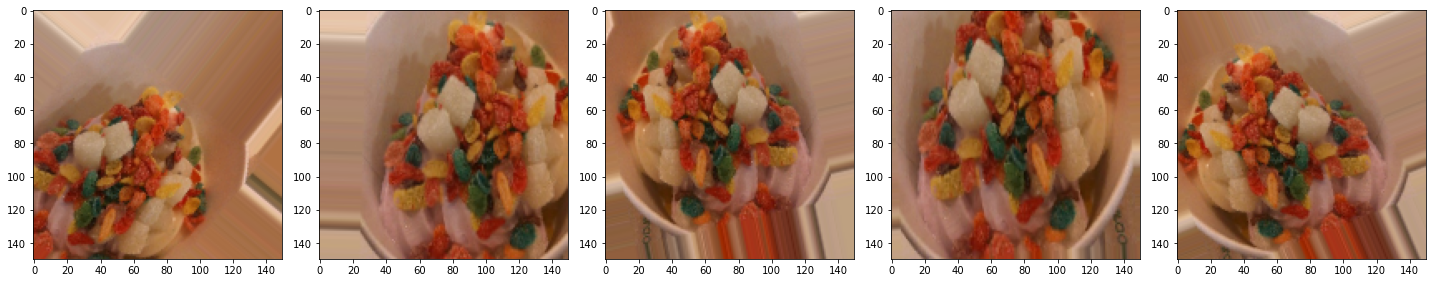

In [13]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [14]:
image_gen_val = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=validation_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

Found 1500 images belonging to 2 classes.


# Build Model

In [15]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [18]:
epochs=100

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "model.h5", save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=30)

history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))),
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100
30/30 [==============================] - 70s 2s/step - loss: 0.6799 - accuracy: 0.6523 - val_loss: 0.3826 - val_accuracy: 0.8200
Epoch 2/100
30/30 [==============================] - 69s 2s/step - loss: 0.3580 - accuracy: 0.8433 - val_loss: 0.4413 - val_accuracy: 0.7953
Epoch 3/100
30/30 [==============================] - 69s 2s/step - loss: 0.3215 - accuracy: 0.8570 - val_loss: 0.2711 - val_accuracy: 0.8947
Epoch 4/100
30/30 [==============================] - 69s 2s/step - loss: 0.2647 - accuracy: 0.8927 - val_loss: 0.2215 - val_accuracy: 0.9127
Epoch 5/100
30/30 [==============================] - 68s 2s/step - loss: 0.2151 - accuracy: 0.9153 - val_loss: 0.1958 - val_accuracy: 0.9220
Epoch 6/100
30/30 [==============================] - 69s 2s/step - loss: 0.1986 - accuracy: 0.9233 - val_loss: 0.1937 - val_accuracy: 0.9260
Epoch 7/100
30/30 [==============================] - 69s 2s/step - loss: 0.1835 - accuracy: 0.9253 - val_loss: 0.1586 - val_accuracy: 0.9400
Epoch 8/100
3

In [19]:
model = tf.keras.models.load_model("model.h5")

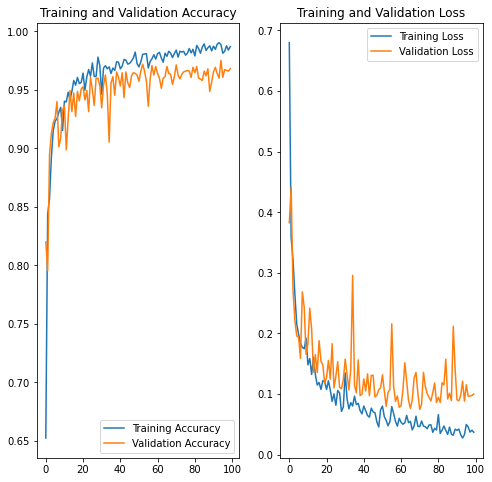

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Save Model

In [21]:
class_labels = ["not_pizza", "pizza"]

## .mlmodel

In [38]:
!pip install coremltools

In [39]:
import coremltools as ct

image_input = ct.ImageType(shape=(1, IMG_SHAPE, IMG_SHAPE, 3,))
classifier_config = ct.ClassifierConfig(class_labels)

converted_model = ct.convert(
    model, inputs=[image_input], classifier_config=classifier_config,
)

converted_model.output_description["classLabel"] = "Pizza or Not Pizza"
converted_model.author = "Pittawat Taveekitworachai"
converted_model.license = "Please see https://github.com/tensorflow/tensorflow for license information."
converted_model.short_description = "Detects the pizza or not pizza image with 99% accuracy from best validation datasets testing."
converted_model.version = "2.0"
converted_model.save("PizzaClassifier.mlmodel")
loaded_model = ct.models.MLModel("PizzaClassifier.mlmodel")

Running TensorFlow Graph Passes:   0%|          | 0/5 [00:00<?, ? passes/s]ERROR:root:Constant Propagation pass failed: invalid version number '2.2.0-dlenv'
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/coremltools/converters/mil/frontend/tensorflow/tf_graph_pass/constant_propagation.py", line 79, in _constant_propagation
    if tf.__version__ < _StrictVersion("1.13.1"):
  File "/opt/conda/lib/python3.7/distutils/version.py", line 64, in __gt__
    c = self._cmp(other)
  File "/opt/conda/lib/python3.7/distutils/version.py", line 168, in _cmp
    other = StrictVersion(other)
  File "/opt/conda/lib/python3.7/distutils/version.py", line 40, in __init__
    self.parse(vstring)
  File "/opt/conda/lib/python3.7/distutils/version.py", line 137, in parse
    raise ValueError("invalid version number '%s'" % vstring)
ValueError: invalid version number '2.2.0-dlenv'
Converting Frontend ==> MIL Ops:   3%|▎         | 1/37 [00:00<00:00, 2739.58 ops/s]


ValueError: Const node 'sequential/conv2d/Conv2D/ReadVariableOp' cannot have no value

## .tflite

In [ ]:
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# with tf.io.gfile.GFile('model.tflite', 'wb') as f:
#   f.write(tflite_model)

# Predict

In [24]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

303104/298849 [==============================] - 1s 3us/step


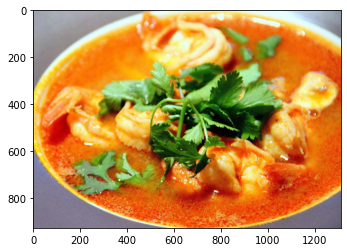

This image most likely belongs to pizza with a 0.7310585975646973 percent confidence.


In [46]:
image_url = "https://lirp-cdn.multiscreensite.com/e2932501/dms3rep/multi/opt/Tom%20Yam%20Kung-1312x928-2880w.jpg"
image_path = tf.keras.utils.get_file('Tom%20Yam%20Kung-1312x928-2880w.jpg', origin=image_url)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(image_path)
imgplot = plt.imshow(img)
plt.show()

img = tf.keras.preprocessing.image.load_img(
    image_path, target_size=(IMG_SHAPE, IMG_SHAPE)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = probability_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {} percent confidence."
    .format(class_labels[np.argmax(score)],  np.max(score))
)

In [49]:
!pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 7.7 MB/s eta 0:00:01


In [54]:
import tensorflow_addons as tfa
from tensorflow_addons.metrics import MultiLabelConfusionMatrix

In [55]:
# multilabel confusion matrix
y_true = tf.constant([[1, 0], [0, 1]],
         dtype=tf.int32)
y_pred = tf.constant([[1, 0],[0, 1]],
         dtype=tf.int32)
output = MultiLabelConfusionMatrix(num_classes=2)
output.update_state(y_true, y_pred)
print('Confusion matrix:', output.result().numpy())

Confusion matrix: [[[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]]
